### Finding best hyper parameters for Task 2

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

Helper functions

In [2]:
def plot_episode_returns(results, title="Episode Return Convergence"):
    """
    Utility function to plot episode returns (can be multiple).
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["episode_returns"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Episode Return")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_policies_and_q_values(Q, label=None):
    """
    Utility function to print policies and corresponding Q values (can be multiple)
    """
    if label:
        print(f"\n===== Optimal Policy for {label} =====")
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = np.argmax(Q[comp_type], axis=0)
        policy[xi[comp_type]] = 1  # Force maintenance at threshold
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)

    print("\nQ-values for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(Q[comp_type])

Define environment

In [3]:
# MDP PARAMETERS
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# TRANSITION PROBABILITIES
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector

Action function

In [4]:
def choose_action(Q: tuple, comp_type: int, s: int, xi: tuple, epsilon: float) -> int:
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - Q         : Tuple of numpy arrays representing the Q-table for each component type.
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - xi        : Tuple containing the failure threshold for each component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1

    # generate random float in the half-open interval [0.0, 1.0)
    if np.random.random() < epsilon:
        # if less than epsilon, choose a random action (exploration)
        return np.random.randint(2)
    else:
        # if greater than epsilon, choose the best action (exploitation)
        return np.argmax(Q[comp_type][:, s])

TESTING

Episodes:   5%|▌         | 520/10000 [00:16<05:06, 30.96it/s]


Stopped early at episode 521 — policy stable for 100 episodes.


Episodes:   6%|▌         | 598/10000 [00:19<05:03, 30.98it/s]


Stopped early at episode 599 — policy stable for 100 episodes.


Episodes:   3%|▎         | 311/10000 [00:09<05:11, 31.10it/s]


Stopped early at episode 312 — policy stable for 100 episodes.


Episodes:   4%|▍         | 406/10000 [00:13<05:30, 29.06it/s]


Stopped early at episode 407 — policy stable for 100 episodes.


Episodes:   6%|▌         | 573/10000 [00:19<05:22, 29.26it/s]


Stopped early at episode 574 — policy stable for 100 episodes.


Episodes:   5%|▍         | 458/10000 [00:15<05:28, 29.09it/s]


Stopped early at episode 459 — policy stable for 100 episodes.


Episodes:   2%|▏         | 170/10000 [00:05<05:33, 29.45it/s]


Stopped early at episode 171 — policy stable for 100 episodes.


Episodes:   4%|▍         | 384/10000 [00:13<05:30, 29.06it/s]


Stopped early at episode 385 — policy stable for 100 episodes.


Episodes:   1%|          | 124/10000 [00:04<05:45, 28.62it/s]


Stopped early at episode 125 — policy stable for 100 episodes.


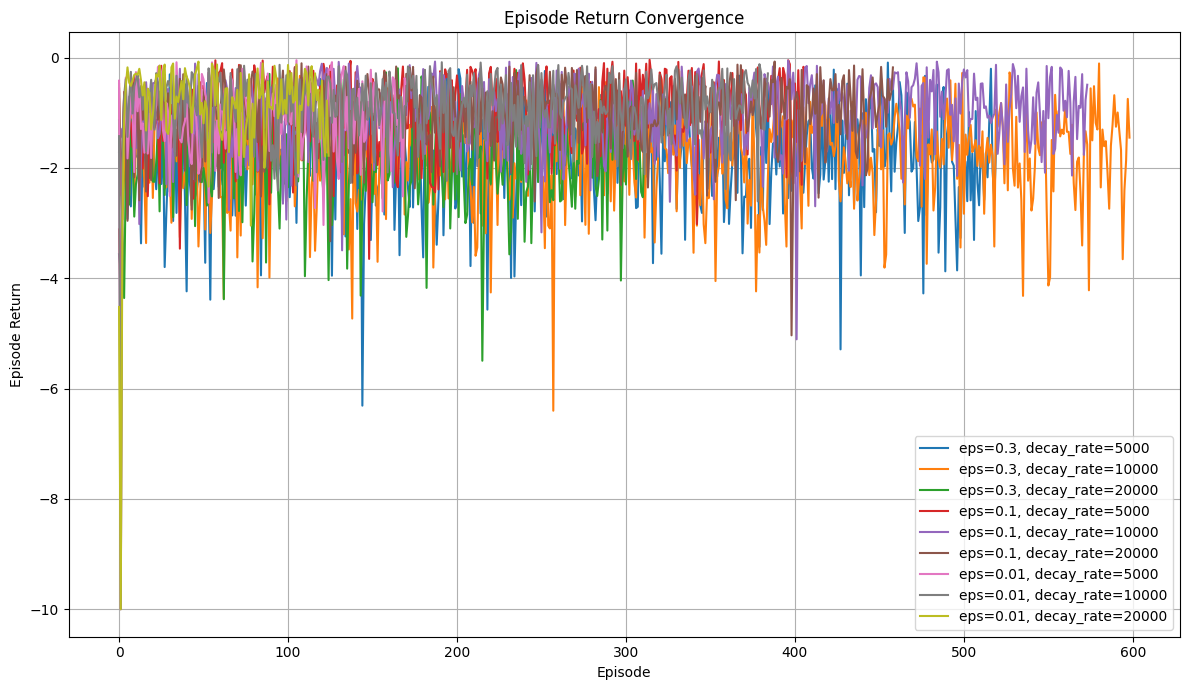


===== Optimal Policy for eps=0.3, decay_rate=5000 =====
Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1]

===== Optimal Policy for eps=0.3, decay_rate=10000 =====
Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 1 1 1 1 1 1]

===== Optimal Policy for eps=0.3, decay_rate=20000 =====
Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Typ

In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm 

############################################################
##       Monte Carlo with Exponential Epsilon Decay       ##
############################################################

# Utility
np.random.seed(0)

def plot_episode_returns(results, title="Episode Return Convergence"):
    """
    Utility function to plot episode returns (can be multiple).
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["episode_returns"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Episode Return")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_policies_and_q_values(Q, label=None):
    """
    Utility function to print policies and corresponding Q values (can be multiple)
    """
    if label:
        print(f"\n===== Optimal Policy for {label} =====")
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = np.argmax(Q[comp_type], axis=0)
        policy[xi[comp_type]] = 1  # Force maintenance at threshold
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)

    # print("\nQ-values for each Component Type:")
    # for comp_type in range(len(xi)):
    #     print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
    #     print(Q[comp_type])

# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Transition probabilities
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector

def choose_action(Q: tuple, comp_type: int, s: int, xi: tuple, epsilon: float) -> int:
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - Q         : Tuple of numpy arrays representing the Q-table for each component type.
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - xi        : Tuple containing the failure threshold for each component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1

    # generate random float in the half-open interval [0.0, 1.0)
    if np.random.random() < epsilon:
        # if less than epsilon, choose a random action (exploration)
        return np.random.randint(2)
    else:
        # if greater than epsilon, choose the best action (exploitation)
        return np.argmax(Q[comp_type][:, s])

def run_simulation(nEpisodes, lengthEpisode, initial_epsilon, min_epsilon=0.01, decay_rate=5000,
                   patience=None):
    
    # ----- initialization -----

    #* initialize Q(s,a) arbitrarily for all s in S and a in A_s
    Q = tuple(np.zeros((2, x + 1)) for x in xi)
    #* Keep track of the number of visits N(s,a)
    N = tuple(np.zeros((2, x + 1)) for x in xi)

    prev_policy = None
    stable_count = 0

    episode_returns = []
    
    for episode_nr in tqdm(range(nEpisodes), desc="Episodes"):
        
        # decay epsilon
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-episode_nr / decay_rate))

        # ----- Generate Episode -----       
        
        # initialize S
        comp_type = np.random.randint(0, 3)
        s = 0 #S[comp_type][0]

        episode_transitions = []  # List to store transitions of the current episode

        # for each step:
        for step in range(lengthEpisode):
            # choose action A using e-greedy policy w.r.t. current Q
            a = choose_action(Q, comp_type, s, xi, epsilon)

            # take action A, observe S'
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                if s_prime > xi[comp_type]:
                    s_prime = xi[comp_type]
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)

            # observe R
            r = -C[comp_type][s][a]

            # append (S, A, R) to a list of episode transitions
            episode_transitions.append((comp_type, s, a, r))

            # transition to S'
            s = s_prime
            comp_type = comp_type_prime

        # ----- Compute returns and update Q -----
        # precompute all returns G_t for the episode in a backward pass
        T = len(episode_transitions) # = lengthEpisode in this case bc no terminal state
        G_t = np.zeros(T)
        G = 0.0
        for t in reversed(range(T)):
            # unpack the transition tuple
            _, _, _, r = episode_transitions[t]

            # recursive computation of G_t
            G = r + gamma*G
            G_t[t] = G

        episode_returns.append(G_t[0])

        # every-visit Monte Carlo: for each state S_t and action A_t in the episode, update Q:
        for t,step in enumerate(episode_transitions):
            # unpack the transition tuple
            comp_type, s, a, _ = step

            # update the visit count: N(s_t, a_t) <- N(s_t, a_t) + 1
            N[comp_type][a,s] += 1

            # update the Q-value: Q(s_t, a_t) <- Q(s_t, a_t) + (1/N(s_t, a_t)) * (G_t - Q(s_t, a_t))
            Q[comp_type][a,s] += (1/N[comp_type][a,s]) * (G_t[t] - Q[comp_type][a,s])


        # ----- Early-stopping based on policy stability -----
        
        if patience is not None:
            current_policy = tuple(np.argmax(Q[comp], axis=0) for comp in range(len(Q)))
            
            # Force maintenance at the threshold
            for k, policy in enumerate(current_policy):
                policy[xi[k]] = 1  

            # Check if the policy is stable
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {episode_nr+1} — policy stable for {patience} episodes.")
                    return Q, episode_returns
            else:
                stable_count = 0
                prev_policy = current_policy
        
    return Q, episode_returns


# number and length of episodes (low for tuning)
nEpisodes = pow(10, 4)
lengthEpisode = pow(10, 3)

hyperparams = [
    {"initial_epsilon": 0.3, "decay_rate": 5_000},
    {"initial_epsilon": 0.3, "decay_rate": 10_000},
    {"initial_epsilon": 0.3, "decay_rate": 20_000},
    {"initial_epsilon": 0.1, "decay_rate": 5_000},
    {"initial_epsilon": 0.1, "decay_rate": 10_000},
    {"initial_epsilon": 0.1, "decay_rate": 20_000},
    {"initial_epsilon": 0.01, "decay_rate": 5_000},
    {"initial_epsilon": 0.01, "decay_rate": 10_000},
    {"initial_epsilon": 0.01, "decay_rate": 20_000},
]

results = {}

for hp in hyperparams:#, desc="Hyperparameter combination"):
    label = f"eps={hp['initial_epsilon']}, decay_rate={hp['decay_rate']}"
    Q, episode_returns = run_simulation(nEpisodes, lengthEpisode, hp['initial_epsilon'], decay_rate=hp['decay_rate'], patience=100)
    results[label] = {"episode_returns": episode_returns, "Q": Q}

plot_episode_returns(results)

# if printPolicies:
for label, data in results.items():
    print_policies_and_q_values(data["Q"], label)

# To run different hyperparameters for testing
# run_all_hyperparam_combos(hyperparams, nEpisodes, lengthEpisode)

Find policy with exact match

In [8]:
target_policy = [
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
    ]
for hp,data in results.items():
    Q = data['Q']
    pi = []
    for comp_type in range(len(xi)):
       policy = np.argmax(Q[comp_type], axis=0)
       policy[xi[comp_type]] = 1
       pi.append([int(i) for i in policy])
    # print(pi)
    if pi == target_policy:
        print(hp,pi)

eps=0.3, decay_rate=5000 [[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]]


Episodes:   1%|▏         | 127/10000 [00:40<52:39,  3.12it/s]

Stopped early at episode 128 — policy stable for 30 episodes.


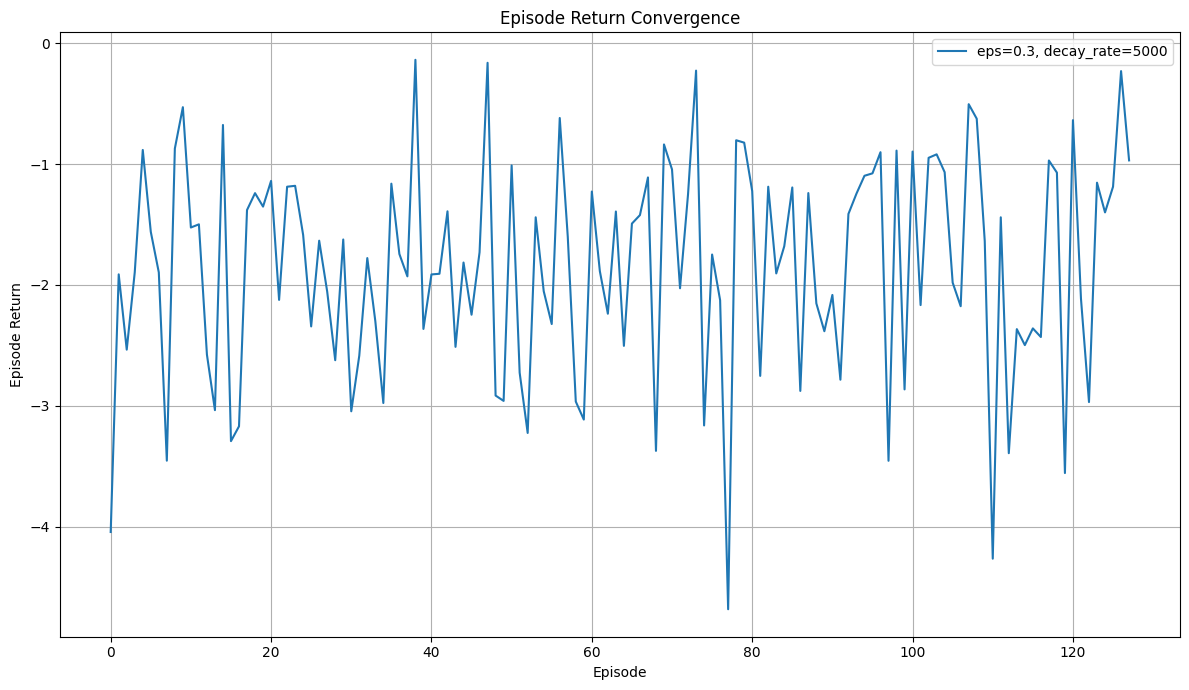


===== Optimal Policy for eps=0.3, decay_rate=5000 =====
Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


In [17]:
# number and length of episodes (low for tuning)
nEpisodes = pow(10, 4)
lengthEpisode = pow(10, 4)

hyperparams = [
    {"initial_epsilon": 0.3, "decay_rate": 5_000},
    # {"initial_epsilon": 0.3, "decay_rate": 10_000},
    # {"initial_epsilon": 0.3, "decay_rate": 20_000},
    # {"initial_epsilon": 0.1, "decay_rate": 5_000},
    # {"initial_epsilon": 0.1, "decay_rate": 10_000},
    # {"initial_epsilon": 0.1, "decay_rate": 20_000},
    # {"initial_epsilon": 0.01, "decay_rate": 5_000},
    # {"initial_epsilon": 0.01, "decay_rate": 10_000},
    # {"initial_epsilon": 0.01, "decay_rate": 20_000},
]

results = {}

for hp in hyperparams:#, desc="Hyperparameter combination"):
    label = f"eps={hp['initial_epsilon']}, decay_rate={hp['decay_rate']}"
    Q, episode_returns = run_simulation(nEpisodes, lengthEpisode, hp['initial_epsilon'], decay_rate=hp['decay_rate'], patience=30)
    results[label] = {"episode_returns": episode_returns, "Q": Q}

plot_episode_returns(results)

# if printPolicies:
for label, data in results.items():
    print_policies_and_q_values(data["Q"], label)

In [13]:
for hp,data in results.items():
    Q = data['Q']
    pi = []
    for comp_type in range(len(xi)):
       policy = np.argmax(Q[comp_type], axis=0)
       policy[xi[comp_type]] = 1
       pi.append([int(i) for i in policy])
    # print(pi)
    if pi == target_policy:
        print(hp,pi)

Task 1 and 2 Comparison

task 1

Episodes:   1%|          | 1084/100000 [00:36<56:01, 29.42it/s]

Stopped early at episode 1085 — policy stable for 100 episodes.


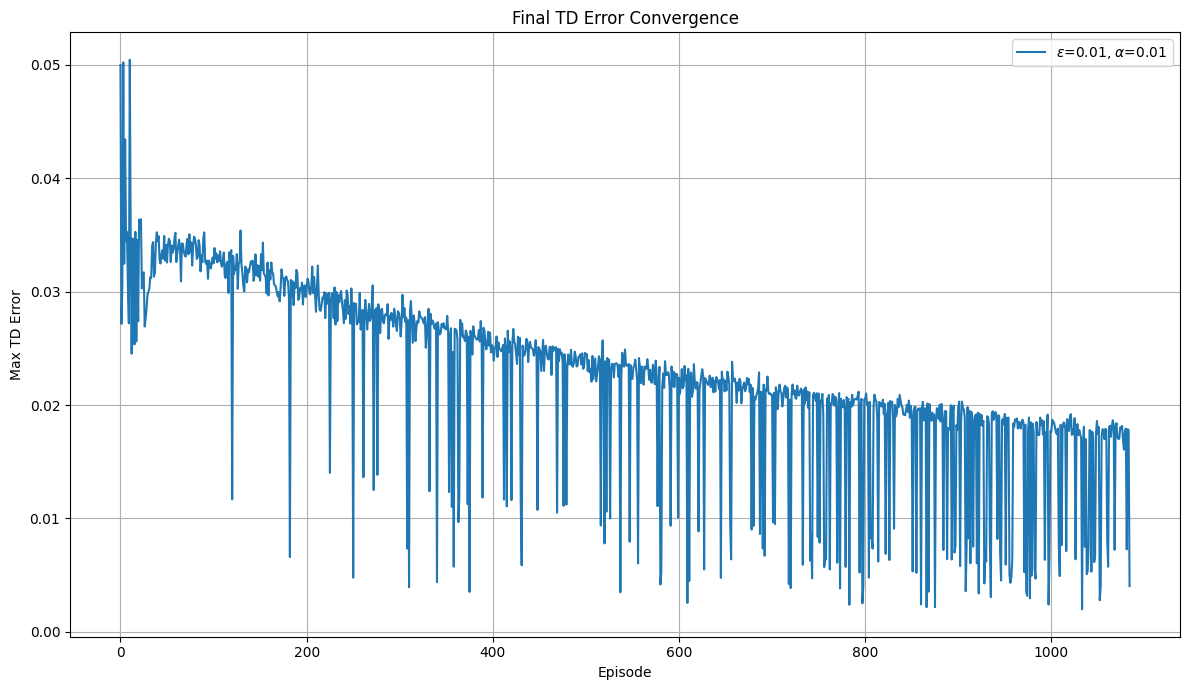

Optimal Policy (0 = Do nothing, 1 = Maintenance):

Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]

Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]

Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1]

Q-values for each Component Type:

Component Type 1 (Failure Threshold = 15):
[[-0.96325807 -1.0095164  -1.07766408 -1.09994073 -1.16998083 -1.21193255
  -1.2622734  -1.35702766 -1.55331324 -1.50951    -1.54430432 -1.68925521
  -1.60669576 -1.63255414 -1.53233308  0.        ]
 [-1.45451061 -1.101362   -1.18857148 -1.24456719 -1.29346414 -1.34630302
  -1.40399878 -1.47873707 -1.49096457 -1.48203493 -1.47135684 -1.470465
  -1.46397315 -1.50125463 -1.48480008 -5.474127  ]]

Component Type 2 (Failure Threshold = 30):
[[-0.47382574 -0.49399621 -0.51252205 -0.54325294 -0.57429374 -0.60234975
  -0.63496371 -0.6640

In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm 

# Utility
np.random.seed(0)

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def print_policies_and_q_values(Q, label=None):
    """
    Utility function to print policies and corresponding Q values (can be multiple)
    """
    if label:
        print(f"\n===== Optimal Policy for {label} =====")
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = np.argmax(Q[comp_type], axis=0)
        policy[xi[comp_type]] = 1  # Force maintenance at threshold
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)

    print("\nQ-values for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(Q[comp_type])

# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Transition probabilities
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector

def choose_action(Q, comp_type, s, xi, epsilon):
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - Q         : Tuple of numpy arrays representing the Q-table for each component type.
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - xi        : Tuple containing the failure threshold for each component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1

    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        return np.argmax(Q[comp_type][:, s])

def run_simulation(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta = 1e-5, patience=None):
    Q = tuple(np.zeros((2, x + 1)) for x in xi)
    td_errors = []
    
    # Initialize list for episode returns.
    episode_returns = []
    
    prev_policy = None
    stable_count = 0
    
    for i in tqdm(range(nEpisodes), desc="Episodes"):
        # Decaying learning rate
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))
        
        # initialize S
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
        
        # Choose A from S using policy derived from Q
        a = choose_action(Q, comp_type, s, xi, epsilon)
        
        max_td_error = 0
        
        # New: Initialize discounted return and discount multiplier.
        episode_return = 0.0
        discount = 1.0  # This will multiply r at each step
        
        for j in range(lengthEpisode):
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                if s_prime > xi[comp_type]:
                    s_prime = xi[comp_type]
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            r = -C[comp_type][s][a]
            
            # New: Accumulate discounted reward.
            episode_return += discount * r
            discount *= gamma  # Update discount multiplier for the next step
            
            a_prime = choose_action(Q, comp_type_prime, s_prime, xi, epsilon)

            # SARSA update
            td_error = r + gamma * Q[comp_type_prime][a_prime][s_prime] - Q[comp_type][a][s]
            Q[comp_type][a][s] += alpha * td_error
            
            if abs(alpha * td_error) > max_td_error:
                max_td_error = abs(alpha * td_error)
            
            # Update S and A for the next step
            s = s_prime
            a = a_prime
        
        td_errors.append(max_td_error)
        
        # New: Record the discounted episode return.
        episode_returns.append(episode_return)
        
        # Early stopping based on stable policy
        if patience is not None:
            current_policy = tuple(np.argmax(Q[comp], axis=0) for comp in range(len(Q)))
            for k, policy in enumerate(current_policy):
                policy[xi[k]] = 1  # Force maintenance at the threshold
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    return td_errors, Q, episode_returns
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping based on TD convergence
        if max_td_error < delta:
            return td_errors, Q, episode_returns
    
    return td_errors, Q, episode_returns

# Final tuned run
nEpisodes = pow(10, 5)
lengthEpisode = pow(10, 3)
epsilon = 0.01
alpha = 0.01
td_errors, Q, ereturns = run_simulation(nEpisodes, lengthEpisode, epsilon, alpha, patience=100)
final_results = {f"$\\epsilon$={epsilon}, $\\alpha$={alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_q_values(Q)

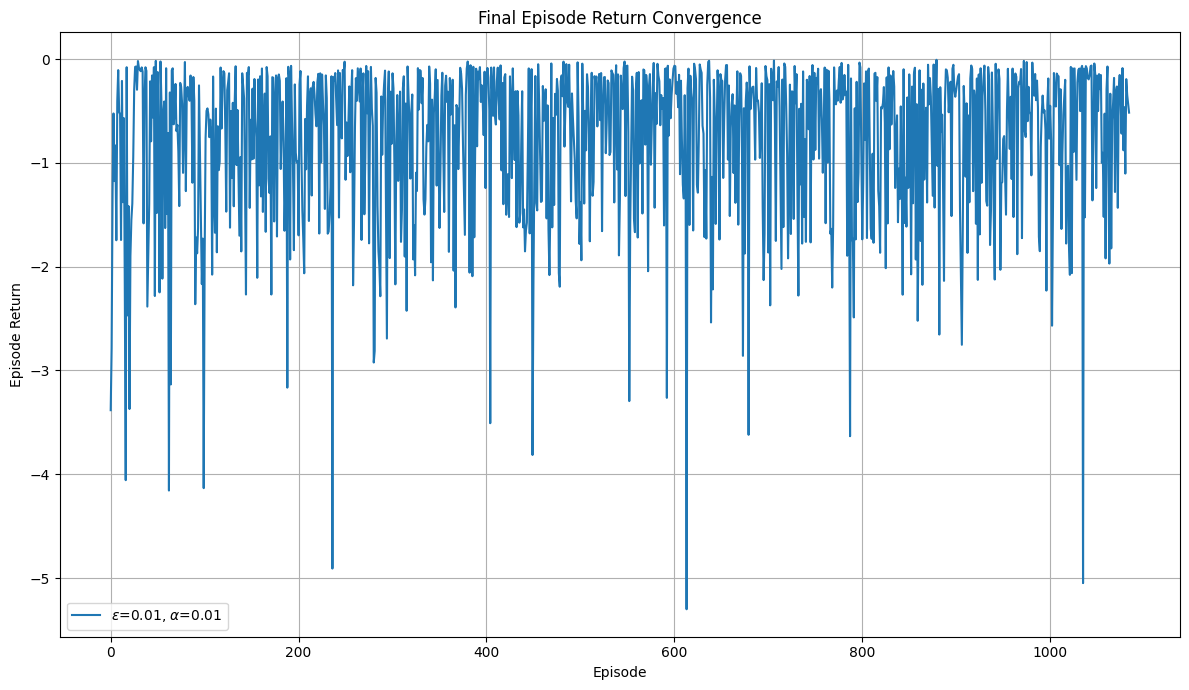

In [26]:
final_results2 = {f"$\\epsilon$={epsilon}, $\\alpha$={alpha}": {"episode_returns": ereturns}}
plot_episode_returns(final_results2, title="Final Episode Return Convergence")

task 2

Episodes:   5%|▌         | 520/10000 [00:16<05:04, 31.17it/s]


Stopped early at episode 521 — policy stable for 100 episodes.


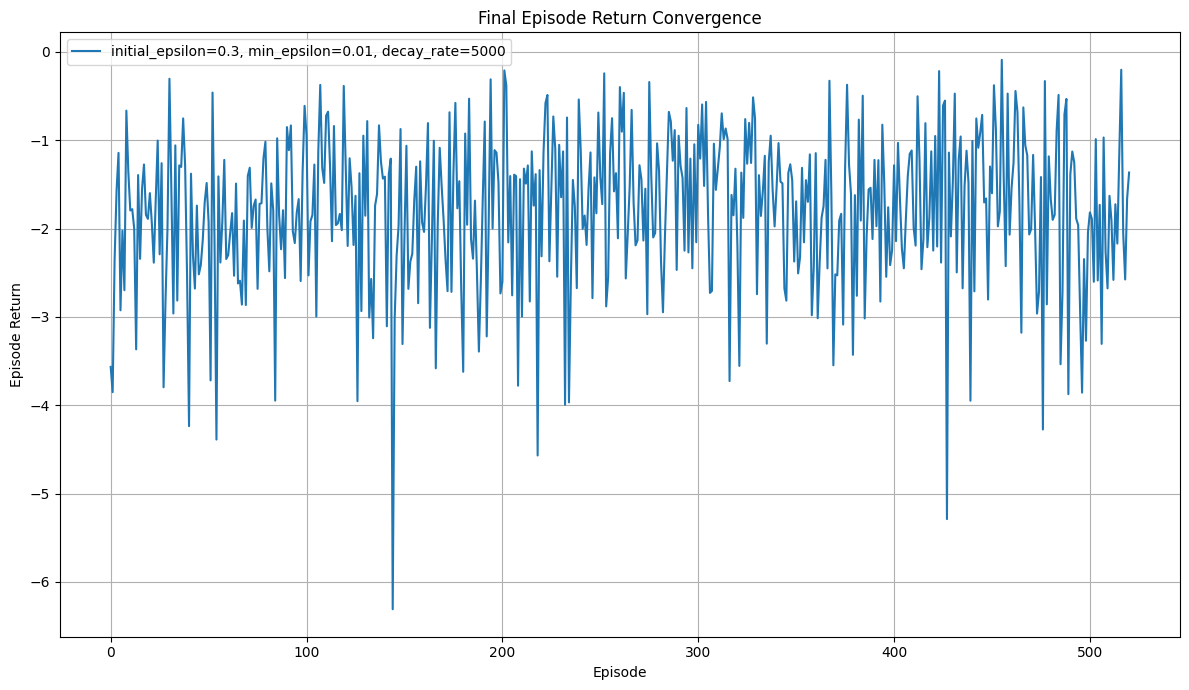


===== Optimal Policy for Final Policy =====
Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1]

Q-values for each Component Type:

Component Type 1 (Failure Threshold = 15):
[[-1.88133173 -1.94718302 -1.98045577 -2.05157112 -2.10373418 -2.18827923
  -2.25715325 -2.36668137 -2.62422939 -2.77896359 -3.08265106 -3.58311129
  -3.97525977 -3.91514612 -4.50402353  0.        ]
 [-2.58210501 -2.61081732 -2.59084751 -2.60176711 -2.58131176 -2.59819473
  -2.6102192  -2.59224094 -2.58025317 -2.55942496 -2.55843642 -2.57974786
  -2.59738705 -2.5956742  -2.53935827 -6.58869181]]

Component Type 2 (Failure Threshold = 30):
[[-1.53043581 -1.55435985 -1.5660675  -1.57458597 -

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm 

############################################################
##       Monte Carlo with Exponential Epsilon Decay       ##
############################################################

# Utility
np.random.seed(0)

def plot_episode_returns(results, title="Episode Return Convergence"):
    """
    Utility function to plot episode returns (can be multiple).
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["episode_returns"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Episode Return")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_policies_and_q_values(Q, label=None):
    """
    Utility function to print policies and corresponding Q values (can be multiple)
    """
    if label:
        print(f"\n===== Optimal Policy for {label} =====")
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = np.argmax(Q[comp_type], axis=0)
        policy[xi[comp_type]] = 1  # Force maintenance at threshold
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)

    print("\nQ-values for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(Q[comp_type])

# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Transition probabilities
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector

def choose_action(Q: tuple, comp_type: int, s: int, xi: tuple, epsilon: float) -> int:
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - Q         : Tuple of numpy arrays representing the Q-table for each component type.
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - xi        : Tuple containing the failure threshold for each component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1

    # generate random float in the half-open interval [0.0, 1.0)
    if np.random.random() < epsilon:
        # if less than epsilon, choose a random action (exploration)
        return np.random.randint(2)
    else:
        # if greater than epsilon, choose the best action (exploitation)
        return np.argmax(Q[comp_type][:, s])


def run_simulation(nEpisodes, lengthEpisode, initial_epsilon, min_epsilon=0.01, decay_rate=5000,
                   patience=None):
    
    # ----- initialization -----

    #* initialize Q(s,a) arbitrarily for all s in S and a in A_s
    Q = tuple(np.zeros((2, x + 1)) for x in xi)
    #* Keep track of the number of visits N(s,a)
    N = tuple(np.zeros((2, x + 1)) for x in xi)

    prev_policy = None
    stable_count = 0

    episode_returns = []

    for episode_nr in tqdm(range(nEpisodes), desc="Episodes"):
        
        # decay epsilon
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-episode_nr / decay_rate))

        # ----- Generate Episode -----       
        
        # initialize S
        comp_type = np.random.randint(0, 3)
        s = 0 #S[comp_type][0]

        episode_transitions = []  # List to store transitions of the current episode

        # for each step:
        for step in range(lengthEpisode):
            # choose action A using e-greedy policy w.r.t. current Q
            a = choose_action(Q, comp_type, s, xi, epsilon)

            # take action A, observe S'
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                if s_prime > xi[comp_type]:
                    s_prime = xi[comp_type]
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)

            # observe R
            r = -C[comp_type][s][a]

            # append (S, A, R) to a list of episode transitions
            episode_transitions.append((comp_type, s, a, r))

            # transition to S'
            s = s_prime
            comp_type = comp_type_prime

        # ----- Compute returns and update Q -----
        # precompute all returns G_t for the episode in a backward pass
        T = len(episode_transitions) # = lengthEpisode in this case bc no terminal state
        G_t = np.zeros(T)
        G = 0.0
        for t in reversed(range(T)):
            # unpack the transition tuple
            _, _, _, r = episode_transitions[t]

            # recursive computation of G_t
            G = r + gamma*G
            G_t[t] = G

        episode_returns.append(G_t[0])

        # every-visit Monte Carlo: for each state S_t and action A_t in the episode, update Q:
        for t,step in enumerate(episode_transitions):
            # unpack the transition tuple
            comp_type, s, a, _ = step

            # update the visit count: N(s_t, a_t) <- N(s_t, a_t) + 1
            N[comp_type][a,s] += 1

            # update the Q-value: Q(s_t, a_t) <- Q(s_t, a_t) + (1/N(s_t, a_t)) * (G_t - Q(s_t, a_t))
            Q[comp_type][a,s] += (1/N[comp_type][a,s]) * (G_t[t] - Q[comp_type][a,s])


        # ----- Early-stopping based on policy stability -----
        
        if patience is not None:
            current_policy = tuple(np.argmax(Q[comp], axis=0) for comp in range(len(Q)))
            
            # Force maintenance at the threshold
            for k, policy in enumerate(current_policy):
                policy[xi[k]] = 1  

            # Check if the policy is stable
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {episode_nr+1} — policy stable for {patience} episodes.")
                    return Q, episode_returns
            else:
                stable_count = 0
                prev_policy = current_policy
        
    return Q, episode_returns

# Final tuned run
nEpisodes = pow(10, 4)
lengthEpisode = pow(10, 3)
initial_epsilon= 0.3
min_epsilon = 0.01
decay_rate = 5_000

Q, episode_returns = run_simulation(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, min_epsilon=min_epsilon, decay_rate=decay_rate, patience=100)
final_results = {f"{initial_epsilon=}, {min_epsilon=}, {decay_rate=}": {"episode_returns": episode_returns}}
plot_episode_returns(final_results, title="Final Episode Return Convergence")
print_policies_and_q_values(Q, label="Final Policy")